<a href="https://colab.research.google.com/github/labviros/computer-vision-topics/blob/master/lesson09-rectified_reconstruction/sparse_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python==4.4.0.44
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 49.5MB 87kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 55.7MB 77kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys

# Return the skew matrix formed from a 3x1 vector 
def skew(vector):
    return np.array([[0, -vector[2], vector[1]], 
                     [vector[2], 0, -vector[0]], 
                     [-vector[1], vector[0], 0]])



In [ ]:
def case_one():
    # Read images
    imgr = cv2.imread('direita.ppm')  # right image
    imgl = cv2.imread('esquerda.ppm') # left image

    # intrinsic parameter matrix

    fm = 403.657593 # Fical distantce in pixels
    cx = 161.644318 # Principal point - x-coordinate (pixels) 
    cy = 124.202080 # Principal point - y-coordinate (pixels) 
    bl = 119.929 # baseline (mm)
    # for the right camera    
    Kr = np.array([[ fm, 0, cx],[0, fm, cy],[0, 0, 1.0000]])
        
    # for the left camera
    Kl = np.array([[fm, 0, cx],[0, fm, cy],[0, 0, 1.0000]])

    # Extrinsec parameters
    # Translation between cameras
    T = np.array([-bl, 0, 0]) 
    T = T/np.linalg.norm(T)
    T_hat = skew(T)
    # Rotation
    R = np.array([[ 1,0,0],[ 0,1,0],[0,0,1]]) 


    # find the keypoints and descriptors with SIFT
    sift = cv2.SIFT_create()
    #sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(imgl,None)
    kp2, des2 = sift.detectAndCompute(imgr,None)

    # Solve matching between detected points in both images
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    good = []
    ptsl = []
    ptsr = []

    # Select good matches
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):

        if m.distance < 0.8*n.distance:
            good.append(m)
            ptsr.append(kp2[m.trainIdx].pt)
            ptsl.append(kp1[m.queryIdx].pt)
         
    ptsl = np.int32(ptsl).T
    ptsr = np.int32(ptsr).T
    

    return imgl,imgr,Kl,Kr,ptsl,ptsr,bl




def case_two():

    #Read images
    imgl = cv2.cvtColor(cv2.imread('270_left.jpg'),cv2.COLOR_BGR2RGB)  #queryimage # left image
    imgr = cv2.cvtColor(cv2.imread('270_right.jpg'),cv2.COLOR_BGR2RGB) #trainimage # right image
    #imgl = cv2.cvtColor(imgl, cv2.COLOR_RGB2GRAY)
    #imgr = cv2.cvtColor(imgr, cv2.COLOR_RGB2GRAY)

    img_size = imgl.shape
    print(img_size)
    imgl = cv2.resize(imgl, (int(img_size[1]/4), int(img_size[0]/4)))

    img_size = imgr.shape
    imgr = cv2.resize(imgr, (int(img_size[1]/4), int(img_size[0]/4)))


    Kl = np.array([[ 2.24534083e+03, -1.86235000e-01,  1.00832942e+03],
                   [ 0.00000000e+00,  2.24106139e+03,  1.02170932e+03],
                   [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

    Kr = np.array([[2.24011968e+03, 2.23877000e-01, 1.01598269e+03],
                   [0.00000000e+00, 2.23629070e+03, 1.03758278e+03],
                   [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
    
    # Correct intrinsic parameters due to resizing images
    Kl = Kl/4
    Kl [-1,-1] = 1
    Kr = Kr/4
    Kr [-1,-1] = 1
    
    Rmat = np.array([[ 0.999995, -0.002636, -0.001449],
                     [ 0.002633,  0.999995, -0.001937],
                     [ 0.001455,  0.001933,  0.999997]])
    Tr = np.array([-4.17709527e+02,-8.92217000e-01,-1.37416000e-01])
    Tr = Tr/np.linalg.norm(Tr)
    T_hat = skew(Tr)
    bl = -Tr[0]

    # find the keypoints and descriptors with SIFT
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(imgl,None)
    kp2, des2 = sift.detectAndCompute(imgr,None)

    # Solve matching between detected points in both images
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    good = []
    ptsl = []
    ptsr = []

    # Select good matches
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):

        if m.distance < 0.7*n.distance:
            good.append(m)
            ptsr.append(kp2[m.trainIdx].pt)
            ptsl.append(kp1[m.queryIdx].pt)

            
    ptsl = np.int32(ptsl).T
    ptsr = np.int32(ptsr).T

    return imgl,imgr,Kl,Kr,ptsl,ptsr,bl

(2046, 2040, 3)


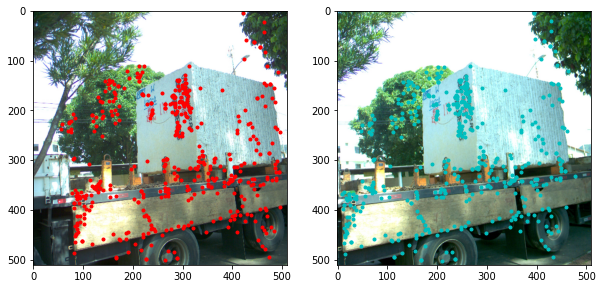

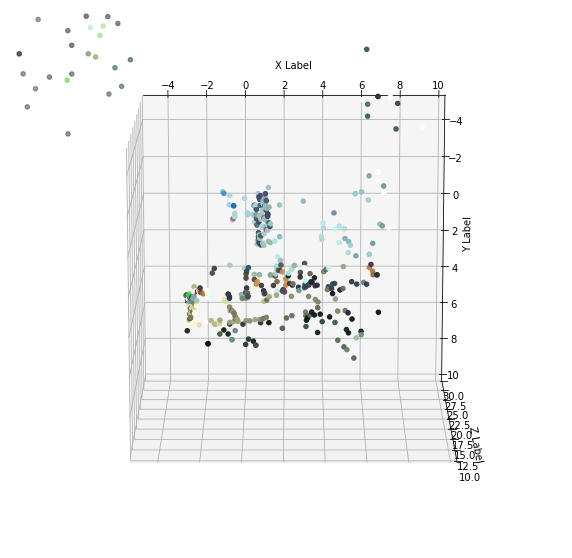

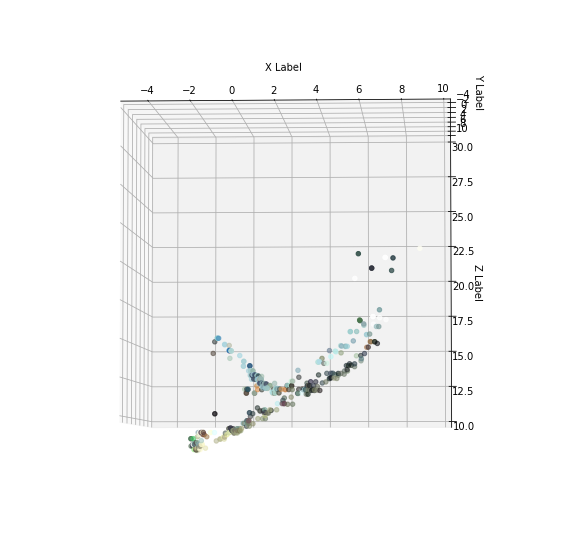

In [ ]:
CASE = 2

if CASE == 1:
    IL,IR,Kl,Kr,ptsl,ptsr,bl = case_one()
   

if CASE == 2:
     IL,IR,Kl,Kr,ptsl,ptsr,bl = case_two()


xpL = ptsl[0,:]
ypL = ptsl[1,:]
xpR = ptsr[0,:]
ypR = ptsr[1,:]

fm = Kl[0,0]
cx = Kl[0,2]
cy = Kl[1,2]




# Eliminates wrong correspondences, comparing the x and y coordinates of the pairs of points

# When images are already rectified, the y-coordinate of the epipolar lines should be the same
# Because we are using images taken from cameras physically aligned and we are (i) not performing a rectification by software, 
# and (ii) using SIFT for fiding correspondences; there may be some noise. 
# So we are eliminating any correspondence detected by SIFT with more than 10 pixles of difference in the y-direction.

error = np.abs(ypL-ypR)
#good = np.zeros(error.shape)
good = np.where(error < 10)

xpL = xpL[good] 
ypL = ypL[good]
xpR = xpR[good]
ypR = ypR[good]


# Because the points were detected and matched using SIFT, we also considered that good correspondences 
# should present disparities less than 100*(minimum disparity +1) - "+1" is used in order to avoid the cases 
# when the minimum is zero 

error = np.abs(xpL-xpR)
err_min = np.min(error)
good = np.where(error < 100*(err_min+1))
xpL = xpL[good]
ypL = ypL[good]
xpR = xpR[good]
ypR = ypR[good]


# Show images and matchings
fig=plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1)
plt.imshow(IL)
plt.plot(xpL,ypL,'r.')
fig.add_subplot(1,2,2)
plt.imshow(IR)
plt.plot(xpR,ypR,'c.')
plt.show(block=False)

# Calculate disparities
disp = xpL-xpR

# Calculate depths
z = np.ones(disp.shape)*fm*bl


z = np.divide(z,disp)

x3d = np.multiply(((xpL - cx)/fm),z)
y3d = np.multiply(((ypL - cy)/fm),z)

# Filter erroneous depths
good = np.where((z>0) & (z<10000))

x3d = x3d[good]
y3d = y3d[good]
z3d = z[good]

xpL = xpL[good]
ypL = ypL[good]

pixel_color=[]

for i in range(xpL.shape[0]):
    pixel_color.append (IL[int(ypL[i]),int(xpL[i])])

pixel_color = np.asarray(pixel_color)

# Plot 3D points with their original colors from the image
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x3d, y3d, z3d, c=pixel_color/255.0)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

if CASE ==1: 
    ax.view_init(elev=-23,azim=-91)
if CASE ==2:
    ax.view_init(elev=-77,azim=-90)
    ax.set_xlim(-5,10)
    ax.set_ylim(-5,10)
    ax.set_zlim(10,30)



fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x3d, y3d, z3d, c=pixel_color/255.0)
#ax.set_aspect('equal')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')



if CASE ==1: 
    ax.view_init(elev=-57,azim=-91)
if CASE ==2:
    ax.view_init(elev=-4,azim=-87)
    ax.set_xlim(-5,10)
    ax.set_ylim(-5,10)
    ax.set_zlim(10,30)


    